In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

iter No.		u		strain			stress			Reaction			R				conv
iter = 1	 u = 2.500000	 strain = 0.001667	 stress = 0.333343	 Reaction = -4000.000000	 Residual = 4.000000e+03	 conv = 4.000000e+03
iter = 2	 u = 2.499931	 strain = 0.001667	 stress = 0.333333	 Reaction = -3999.888889	 Residual = -1.111111e-01	 conv = 1.111111e-01
iter = 3	 u = 2.499931	 strain = 0.001667	 stress = 0.333333	 Reaction = -3999.888898	 Residual = 9.259003e-06	 conv = 9.259003e-06
iter = 4	 u = 2.499931	 strain = 0.001667	 stress = 0.333333	 Reaction = -3999.888898	 Residual = -7.717063e-10	 conv = 7.717063e-10


C:\Users\paran\AppData\Local\Temp\ipykernel_5304\2484874184.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  qu[i - 1] -= A*sigma(dU/dx)
C:\Users\paran\AppData\Local\Temp\ipykernel_5304\2484874184.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  qu[i - 1] += A*sigma(dU/dx)
C:\Users\paran\AppData\Local\Temp\ipykernel_5304\2484874184.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('iter = %d\t u = %.6f\t strain = %.6f\t stress = %.6f\t Reaction = 

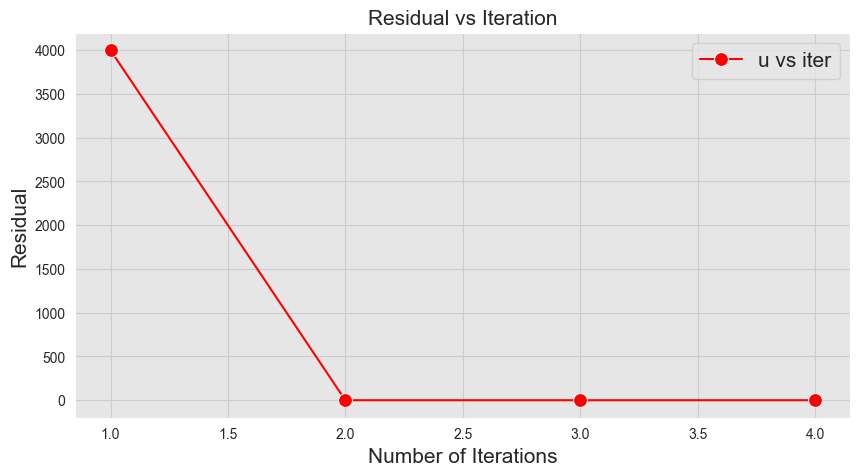

In [2]:
def sigma(U):
    E0 = 200
    # s = E0 * U
    s = E0 * U + 10*E0 * U**3
    return s

def sigma_dash(U):
    E0 = 200
    # s_dash = E0
    s_dash = E0 + 10*E0 * 3*U**2
    return s_dash

# Constants
bc = 1  # Boundary condition
A = 300*40     # Cross-sectional area of the bar
L = 1500.0     # Length of the bar
f = 4000   # Applied load
tol = 1e-6  # Tolerance for convergence
maxiter = 100  # Maximum number of iterations

numberElement = 4
elementNodes = []
for i in range(1, numberElement+1):
    elementNodes.append([i, i+1])
# print(elementNodes)

numberNode = numberElement + 1

# Initialization
# U_0 = np.array([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])     # Initial displacement
U_0 = np.zeros([numberNode,1])
l = L/numberElement
strain = (U_0/l)
stress = sigma(U_0/l) # Initial stress



def delu_generator(U, f):

    force = np.zeros([numberNode,1])
    stiffness = np.zeros([numberNode,numberNode])

    force[-1] = f

    for i,ii in enumerate(elementNodes):

        k = np.matrix([[0, 0], [0, 0]])

        k[0,0] = A*(sigma_dash((U[i+1][0]-U[i][0])*(1/l))*(-1/l)*(-1/l))*l
        k[0,1] = A*(sigma_dash((U[i+1][0]-U[i][0])*(1/l))*(-1/l)*(1/l))*l
        k[1,0] = A*(sigma_dash((U[i+1][0]-U[i][0])*(1/l))*(1/l)*(-1/l))*l
        k[1,1] = A*(sigma_dash((U[i+1][0]-U[i][0])*(1/l))*(1/l)*(1/l))*l

        stiffness[ii[0]-1:ii[-1], ii[0]-1:ii[-1]] = stiffness[ii[0]-1:ii[-1], ii[0]-1:ii[-1]] + k

    # Function to apply Boundary Conditions
    def BC(K, bc):
        newK = []
        for i in range(len(K)):
            temp = []
            for j in range(len(K[0])):
                if not(i==bc or j==bc):
                    temp.append(K[i][j])
            if temp != []:
                newK.append(temp)
        return np.matrix(newK)
    
    s = BC(stiffness, bc-1)

    N = len(U) - 1
    qu = np.zeros(N)
    for i in range(1, (N + 1)):
        dx = l
        dU = U[i] - U[i - 1]
        qu[i - 1] -= A*sigma(dU/dx)
        
        if i < N:
            dx = l
            dU = U[i + 1] - U[i]
            qu[i - 1] += A*sigma(dU/dx)

    qu[N - 1] += f 
    R = qu.copy()

    u = np.linalg.solve(s, R)

    displacements = [[0]]
    for j in u:
        displacements.append([j])

    return (np.array(displacements)), R, stiffness

U = U_0
delu, R, stiffness = delu_generator(U_0, f)

conv = np.linalg.norm(R)
# Headers for output
print('iter No.\t\tu\t\tstrain\t\t\tstress\t\t\tReaction\t\t\tR\t\t\t\tconv')

iter = 0
# print('iter = %d\t u = %.6f\t strain = %.6f\t stress = %.6f\t R = %.6e\t conv = %.6e' % (iter, U[-1], strain[-1][-1], stress[-1][-1], R[-1], conv))

iter_x = []
delu_y = []
# iter_x.append(iter)
# delu_y.append(U[-1][-1])

# Newton-Raphson iteration
while (conv > tol and iter < maxiter):
    iter += 1  # Increase iteration count
    delu, R, stiffness = delu_generator(U, f)  # Increment in displacement
    
    U = U + delu # Update displacement
    strain = []
    for i in elementNodes:
        strain.append(np.matmul(np.matrix([-1, 1]), np.matrix(U[i[0]-1:i[1]]))/l)   # Update strain

    stress = sigma(np.array(strain)) # Update stress

    def outputDisplacementsReactions(displacements,stiffness,R):
        r = R.copy()
        r = np.insert(r,0,0.0)
        reactions=np.matmul(stiffness, displacements) # Calculating reactions
        return reactions
    
    reaction = outputDisplacementsReactions(U,stiffness,R)

    
    iter_x.append(iter)
    delu_y.append(R[-1])

    conv = np.linalg.norm(R)

    # Print results
    print('iter = %d\t u = %.6f\t strain = %.6f\t stress = %.6f\t Reaction = %.6f\t Residual = %.6e\t conv = %.6e' % (iter, U[-1], strain[-1][-1], stress[-1][-1], reaction[0,0], R[-1], conv))

U_FEM = U
fig, ax = plt.subplots()
sns.lineplot(x=iter_x, y=delu_y, color='red', marker='o', markersize=10, label = 'u vs iter', ax=ax)
plt.title('Residual vs Iteration', fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Number of Iterations', fontsize=15)
plt.ylabel('Residual', fontsize=15)

plt.legend(fontsize=15) 

In [3]:
U_FEM, stress, reaction

(array([[0.        ],
        [0.62498264],
        [1.24996528],
        [1.87494792],
        [2.49993056]]),
 array([[[0.33333333]],
 
        [[0.33333333]],
 
        [[0.33333333]],
 
        [[0.33333333]]]),
 array([[-3.99988890e+03],
        [ 0.00000000e+00],
        [ 0.00000000e+00],
        [ 1.36424205e-12],
        [ 3.99988890e+03]]))

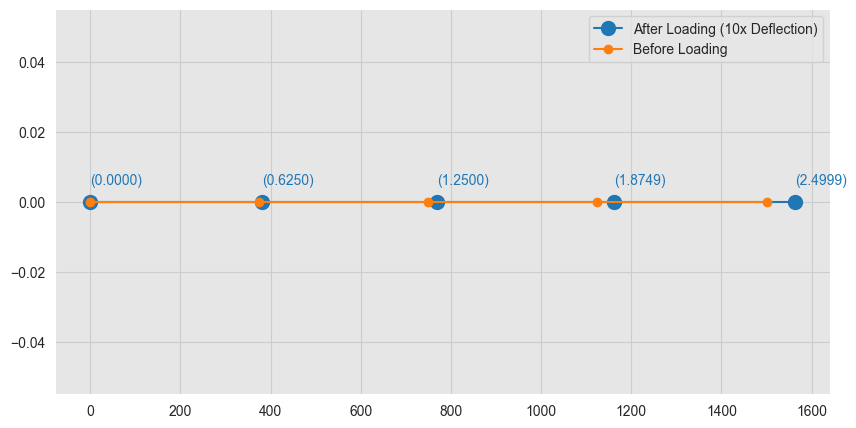

In [4]:
Multiplier = 1*10**1
x = [[0]]
te = 0
for i in range(len(U_FEM)-1):
    te = te + l
    x.append([te])
x = np.matrix(x)

y = [[0]]
te = 0
for i in range(len(U_FEM)-1):
    te = te + l + U_FEM[i+1,0]*Multiplier
    y.append([te])
y = np.matrix(y)


plt.plot(y, np.zeros([y.size,1]), marker='o', color='tab:blue', markersize=10, label=f'After Loading ({Multiplier}x Deflection)')
ind = 0
for i in zip(y,np.zeros([y.size,1])):
    plt.annotate('(%.4f)'% (U_FEM[ind,0]), xy=i, xytext=(y[ind],0.005), color='tab:blue')
    ind = ind+1

plt.plot(x, np.zeros([x.size,1]), marker='o', color='tab:orange', label='Before Loading')
plt.legend()